In [1]:
import xarray as xr
import numpy as np
from datetime import datetime
import time
import netCDF4 as nc
import mpl_toolkits
import geopandas ## in order for the basemap to be imported successfully, geopandas needs to be installed also
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import xesmf as xe ## used for regridding the outputs
from nco import Nco

### 1. Prepare the satellite dataset

In [2]:
LN1=0
LN2=19

LT1=-34
LT2=-13

## identify the beginning (T1) and end (T2) of timeframe of interest in the format (YYYY-MM-DD)
T1='1993-01-01'
T2='2014-12-31'

ghrsst_all='/home/jenny/Data/REMOTE/GHRSST/ghrsst_GDS2_L4_CMC.nc'
DS=xr.open_dataset(ghrsst_all,decode_times=False)
a=DS.coords['time'].values
local_time = nc.num2date(a, units='seconds since 1981-01-01 00:00:00') 
## then copy the decoded back into the dataset
lt=xr.DataArray(local_time,dims='time')
DS['time'].values=lt.values
### subset the dataset for the region of interest and the time period of interest as specified above
DS_SUB=DS.loc[dict(time=slice(T1,T2),lat=slice(LT1,LT2),lon=slice(LN1,LN2))]

DS_SUB['analysed_sst']=DS_SUB['analysed_sst']-273.15
## extract season of interest (as specified above)

## create a monthly mean
DS_MM=DS_SUB['analysed_sst'].resample(time="1MS").mean(dim="time")

DM_MASK=DS_SUB['mask'].resample(time="1MS").mean(dim="time")

In [5]:
import numpy as np

## choose the number of pixels to extract from coast
npi=2

## replace all values not == 1 with NAN (i.e. create land mask)
DM_MASK2=DM_MASK.where(DM_MASK==1)
mask_array=DM_MASK2.values

## sum the masked ocean in order to find the index of the postion of the pixel next to coast (subtract 1 because indexing starts at 0)
index=np.nansum(mask_array,2)-1

## create a 3D mask 
mask_array2=mask_array.copy()

for idx, val in enumerate(index[0,:]):
    #print val
    i2=int(val-npi)
    mask_array2[:,idx,0:i2]=np.nan
    
## and use it to create a hofmoeller of coastal SST
DM_SST_strip=DS_MM.values*mask_array2

DM_SST_hoff=np.nanmean(DM_SST_strip,axis=2)

## create a data array with the hoffmoeller plot and coords
time=DS_MM['time'].values
lat=DS_MM['lat'].values

DM_HOFF=xr.DataArray(DM_SST_hoff,dims=['time','lat'],coords={'time':time,'lat':lat})

In [6]:
### here we calculate the climatology and anomalies
import pandas as pd
import matplotlib.dates as md
import dateutil
import xarray as xr


### calculate the climatology, monthly means and anomalies:
var1_clim=DM_HOFF.groupby('time.month').mean('time')
var1_std=DM_HOFF.groupby('time.month').std('time')

var1_anom0=DM_HOFF.groupby('time.month')-var1_clim
var1_anom=var1_anom0.groupby('time.month')/var1_std


/home/jenny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/jenny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:175: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/jenny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:176: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


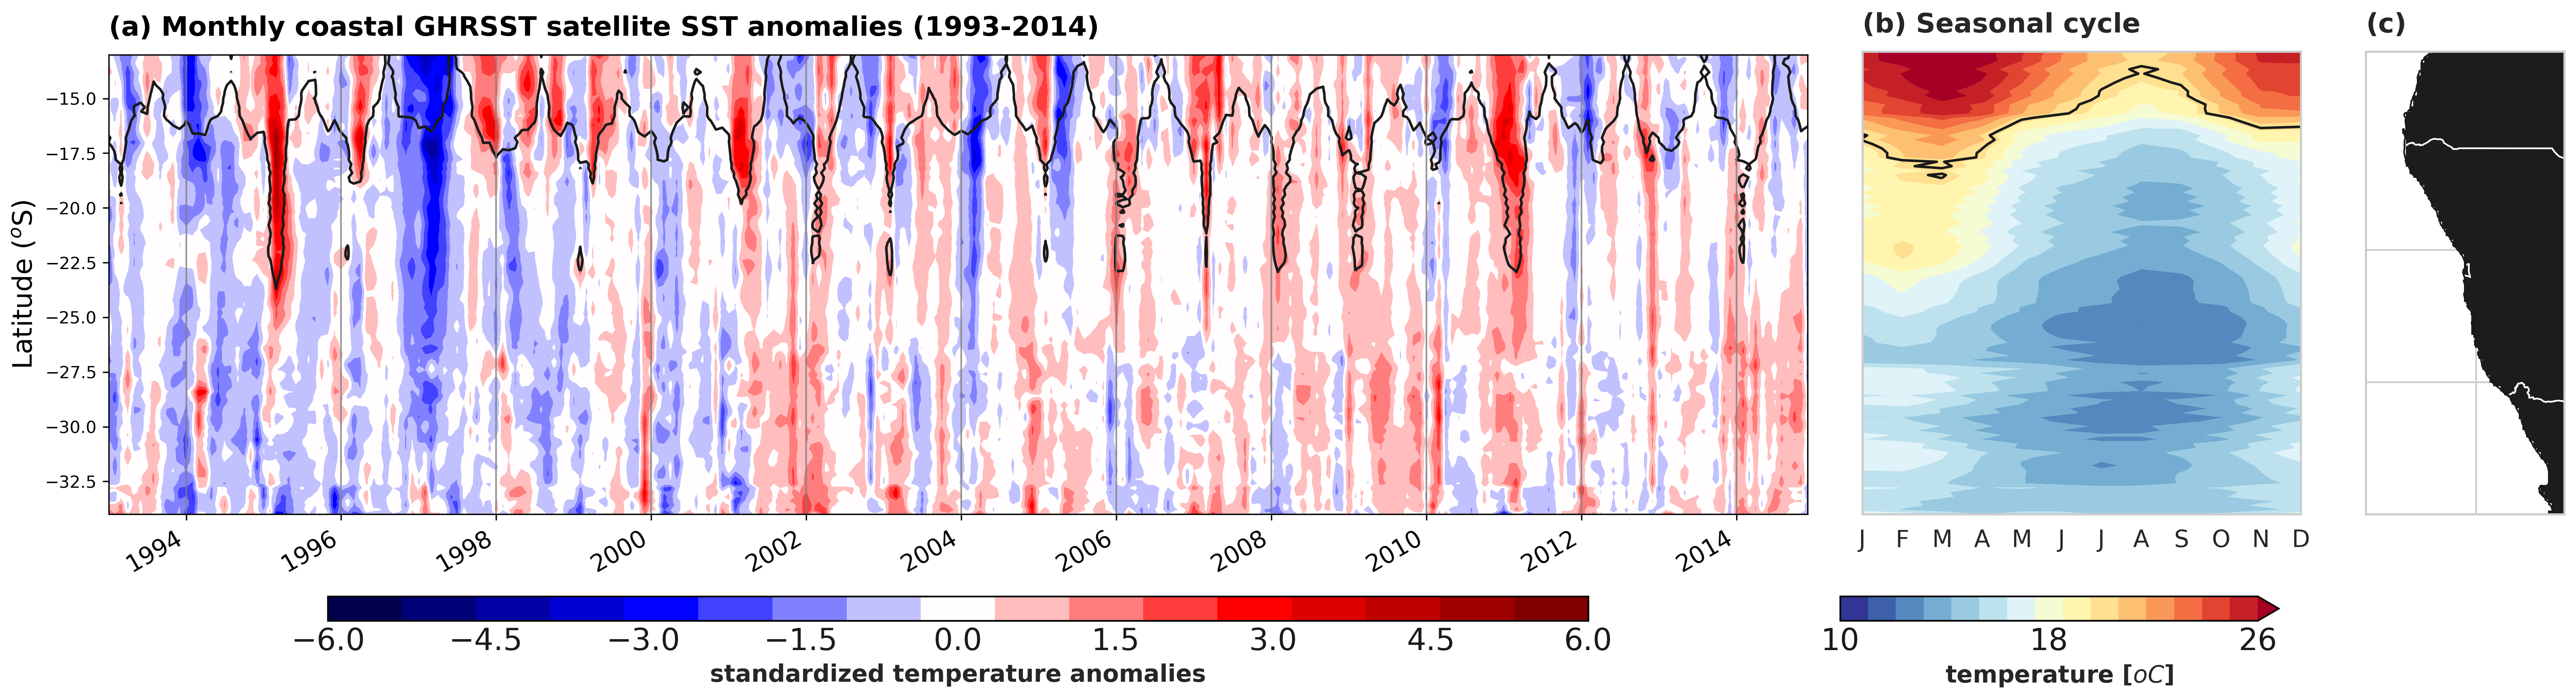

In [5]:
import datetime as dt
import seaborn as sns
import matplotlib.dates as mdates
import geopandas ## in order for the basemap to be imported successfully, geopandas needs to be installed also
from mpl_toolkits.basemap import Basemap
from matplotlib.dates import MonthLocator, YearLocator

## plot the data
#fig = plt.figure(figsize=(18,7),dpi=300, facecolor='white')
#ax1 = fig.add_subplot(1,1,1)

#####PLOTTING STUFF 
T1='1993-01-01'
T2='2014-12-31'

fig = plt.figure(figsize=(18,5),dpi=300, facecolor='white')
ax1 = fig.add_subplot(111)

### plot hoffmoeller plot of var 1 for selected year
sns.set(style="whitegrid")

Y=var1_anom0['lat']
#X=var1_anom0['time'].values.as_matrix(columns=None)
X=var1_anom0['time']
Z=(var1_anom0).T
#X=var1_anom0['time'].as_matrix(columns=None)
Z1=DM_HOFF.T

zmin=-6
zmax=6

#zint=0.01
zlevels=18;

ymin=-34
ymax=-13

## major x ticks
txposition = [pd.to_datetime('1994'), pd.to_datetime('1996'), pd.to_datetime('1998'), pd.to_datetime('2000'), pd.to_datetime('2002'), pd.to_datetime('2004'), pd.to_datetime('2006'), pd.to_datetime('2008'), pd.to_datetime('2010'), pd.to_datetime('2012'), pd.to_datetime('2014')] 
## major y ticks
yxposition = [-28,-22] 

cs=Z.plot.contourf(cmap='seismic', vmin=zmin, vmax=zmax,levels=zlevels,add_colorbar=False)
Z1.plot.contour(levels=[20], add_colorbar=False,colors=['k'])
ax1.set_ylim(ymin,ymax)



hfmt = md.DateFormatter('%Y')
year = [1994,1996,1998,2000,2002,2004,2006,2008,2010,2012,2014]
dates = [dt.datetime.strptime(str(int(date)),'%Y') for date in year]
xfmt = mdates.DateFormatter('%Y')

ax1.xaxis.set_major_formatter(xfmt)
ax1.set_xticks(dates,minor=False)
labels = ax1.get_xticklabels()
plt.setp(labels, fontsize=14)

for xc in txposition:
    ax1.axvline(x=xc, color='grey', linestyle='-',lw=1,alpha=0.8)
    
    ### add major axis ticks (grid doesn't work in jupyter notebook this is a workaround)
#for xc in yxposition:
#    ax1.axhline(y=xc, color='grey', linestyle='-',lw=1,alpha=0.8)


_=ax1.set_ylabel(u'Latitude ($^{o}$S)', size=16)
_=ax1.set_xlabel(u'', size=14)
# Title    
_ = ax1.set_title('(a) Monthly coastal GHRSST satellite SST anomalies (1993-2014)',loc='left',fontsize='16', weight='bold', y=1.02)


cax1 = fig.add_axes([0.225, -0.05, 0.575, 0.04])

cticks=np.linspace(zmin,zmax,zlevels/2)
cb0 = plt.colorbar(cs, orientation = 'horizontal', cax=cax1, ticks=cticks, extend='both', drawedges=True)
cb0.ax.tick_params(axis='x',direction='in', length=7, width=1, colors='k', top='on', labelsize='18')
#cb = plt.colorbar(cs, orientation = 'horizontal',fraction=0.075,ticks=cticks, extend='both', drawedges=True)
#cb.ax.tick_params(axis='x',direction='in', length=7, width=1, colors='k', top='on', labelsize='14')
#[h.set_zorder(0) for h in cb0.ax.findobj(mpl.collections.QuadMesh)]
cb0.set_label('standardized temperature anomalies', fontsize='14', weight='bold')
cb0.outline.set_edgecolor('black')
cb0.outline.set_linewidth(1)
#cb.dividers.set_edgecolor('black')
cb0.dividers.set_linewidth(0)

##############################################################################
### SEASONAL CYCLE
##############################################################################

#cax = fig.add_axes([0.915, 0.31875, 0.20, 0.5813]) ### from print ax.get_position() to work out the values
#cax = fig.add_axes([0.915, 0.1, 0.2, 0.595])
cax = fig.add_axes([0.925, 0.125, 0.20, 0.76])
sns.set(style="whitegrid")

Y=var1_clim['lat']
X=var1_clim['month']
Z=var1_clim.T

smin=10
smax=26
slevels=16

csm=Z.plot.contourf(cmap='RdYlBu_r', vmin=smin, vmax=smax,levels=slevels,add_colorbar=False)
cs=Z.plot.contour(levels=[20], add_colorbar=False,colors=['k'])
#csm=plt.pcolor(timeallc, latallc, ws_clim, cmap=cmap_s, norm=norm_s, zorder=0)
csm.set_clim(smin,smax)

#ax.set_ylim(-35,-12);
#ax.set_xlim(0,12);

### X-Axis
months_lab = ['J','F', 'M', 'A', 'M', 'J', 'J','A', 'S', 'O', 'N', 'D']
cax.set_xlim(1,12)
cax.set_xticks(np.linspace(1,12,12))
cax.set_xticklabels(months_lab, size='14');
cax.tick_params(axis='x', direction='inout', which = 'major', length=10, width=1)
_=cax.set_xlabel(u'')
### Y-Axis
cax.set_ylim(-34,-13);
cax.set_yticks(np.arange(-28,-21, 6.));

cax.set_yticklabels('');
cax.tick_params(axis='y', direction='inout', which = 'major', length=8, width=2)
cax.grid(axis='y', linestyle='-', alpha=0.4)

### Outerbox
#for sp_name,sp_obj in cax.spines.iteritems():
#    sp_obj.set_lw(2) #linewidth
#    sp_obj.set_edgecolor('k')

# Title    
_ = cax.set_title('(b) Seasonal cycle',loc='left',fontsize='16', weight='bold', y=1.02)    
    

_=cax.set_ylabel(u'')

##############################################################################

### Add a colobar - have to add another axes just so that there is one cb for the whole plot
cax = fig.add_axes([0.915, -0.05, 0.2, 0.04])
cticks=np.linspace(smin,smax,3)
#cb = plt.colorbar(csm, orientation = 'horizontal', cax=cax, ticks=cticks, extend='both', drawedges=True)
cb = plt.colorbar(csm, orientation = 'horizontal', cax=cax, ticks=cticks)
cb.ax.tick_params(axis='x',direction='in', length=7, width=1, colors='k', top='on', labelsize='18')
#[h.set_zorder(0) for h in cb.ax.findobj(mpl.collections.QuadMesh)]
cb.set_label('temperature [${o}C$]', fontsize='14', weight='bold')
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1)
#cb.dividers.set_edgecolor('black')
#cb.dividers.set_linewidth(0)
#cb.add_lines(cp)

### Save figure
#plt.savefig(outpath + 'DFS_10speedanoms_hovmoller_b.png', dpi = 300, bbox_inches='tight')


###############################################################################################



#### plot the map 
#wax = fig.add_axes([1.09, 0.3, 0.2, 0.595])
wax = fig.add_axes([1.10, 0.125, 0.2, 0.76]) #0.775

sns.set(style="whitegrid")

lonmax=19
lonmin=10
latmin=-34
latmax=-13

#### Summer
map_ax=Basemap(resolution='i',projection='cyl',llcrnrlat=latmin, llcrnrlon=lonmin, urcrnrlat=latmax, urcrnrlon=lonmax, \
               ax=wax)
map_ax.drawcountries(linewidth=1,color='w')
map_ax.drawcoastlines(linewidth=1)
map_ax.drawlsmask(land_color='k', ocean_color='none', lakes=False, alpha = 0.99, zorder=1, resolution='i')

_= map_ax.ax.set_yticks(np.arange(-28,-21,6.))
_= map_ax.ax.set_xticks(np.arange(lonmin,lonmax,5.)) 

wax.tick_params(labelleft=False)
wax.tick_params(labelbottom=False)


### Outerbox
#for sp_name,sp_obj in wax.spines.iteritems():
#    sp_obj.set_lw(2) #linewidth
#    sp_obj.set_edgecolor('k')

# Title    
_ = wax.set_title('(c)',loc='left',fontsize='16', weight='bold', y=1.02)  


In [7]:
### calculate the climatology, monthly means and anomalies BUT NAN out a range of smaller anoms
var1_clim=DM_HOFF.groupby('time.month').mean('time')
var1_std=DM_HOFF.groupby('time.month').std('time')

var1_anom0=DM_HOFF.groupby('time.month')-var1_clim
var1_anom=var1_anom0.groupby('time.month')/var1_std

Z=(var1_anom0).T
zz=Z.values
zz1=abs(zz)
unit=zz/zz1

zz1[zz1<2]=np.nan

Znew=zz1*unit

var1_anom0.values=Znew.T

/home/jenny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/jenny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:175: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/jenny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:176: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


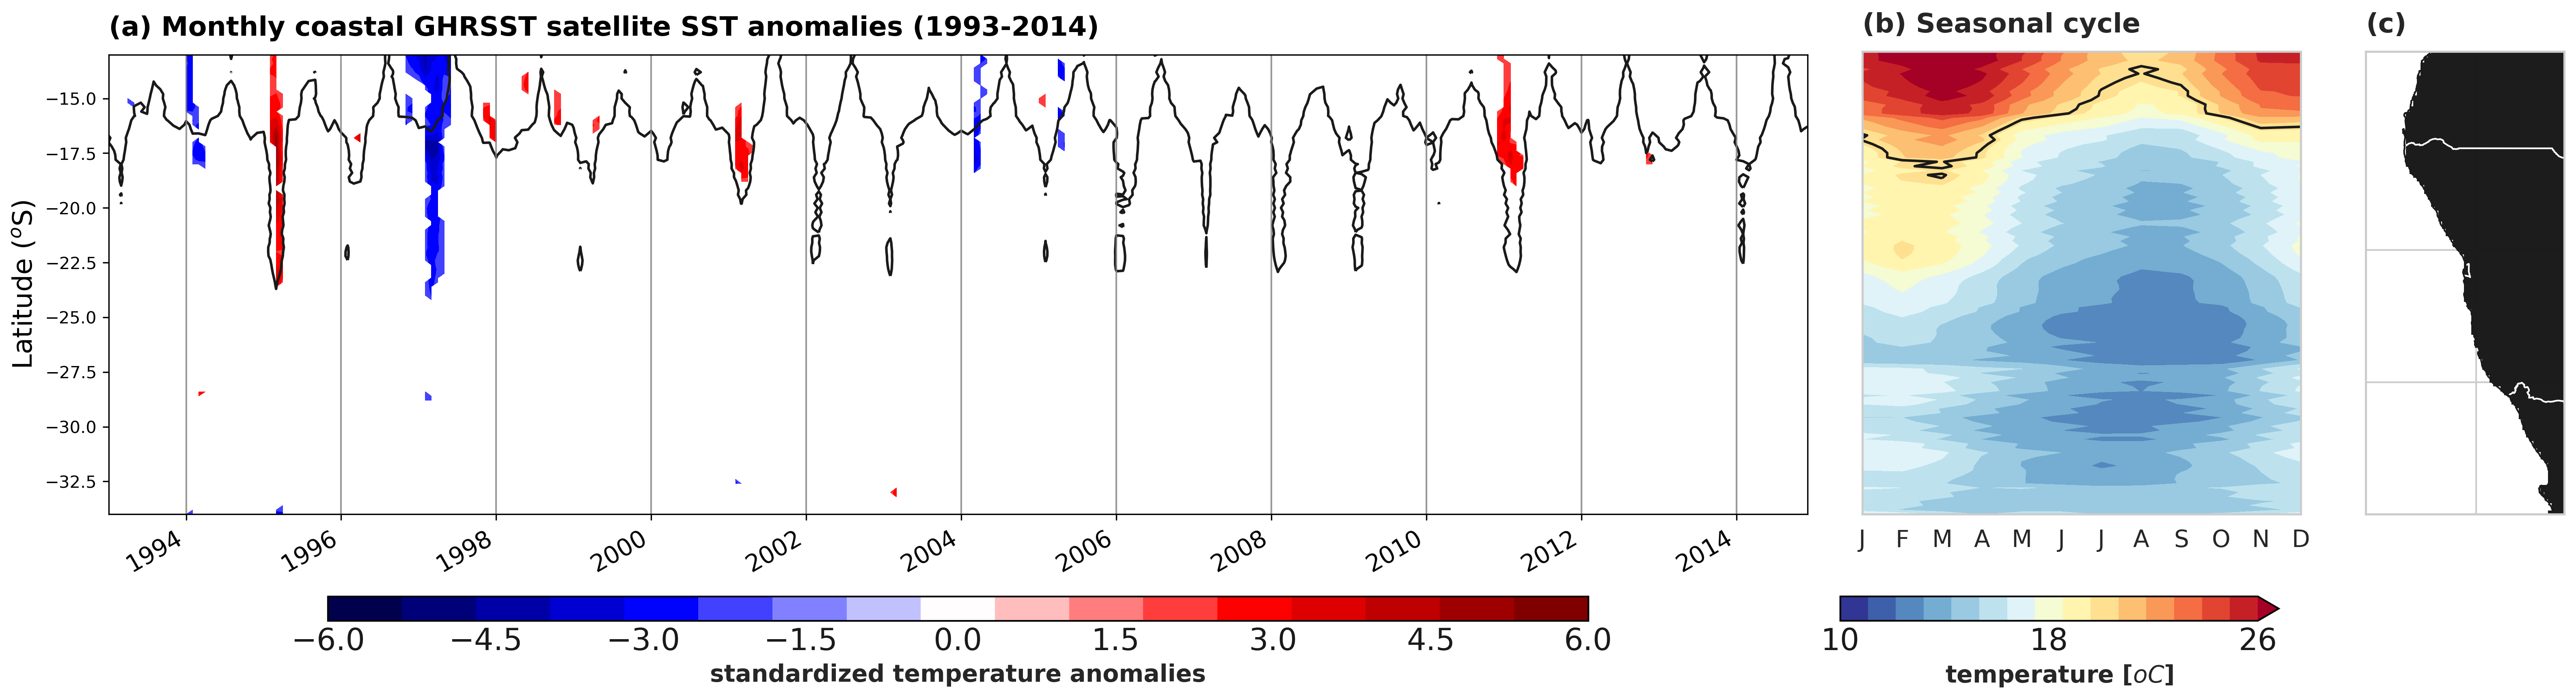

In [8]:
import datetime as dt
import seaborn as sns
import matplotlib.dates as mdates
import geopandas ## in order for the basemap to be imported successfully, geopandas needs to be installed also
from mpl_toolkits.basemap import Basemap
from matplotlib.dates import MonthLocator, YearLocator

## plot the data
#fig = plt.figure(figsize=(18,7),dpi=300, facecolor='white')
#ax1 = fig.add_subplot(1,1,1)

#####PLOTTING STUFF 
T1='1993-01-01'
T2='2014-12-31'

fig = plt.figure(figsize=(18,5),dpi=300, facecolor='white')
ax1 = fig.add_subplot(111)

### plot hoffmoeller plot of var 1 for selected year
sns.set(style="whitegrid")

Y=var1_anom0['lat']
#X=var1_anom0['time'].values.as_matrix(columns=None)
X=var1_anom0['time']
Z=(var1_anom0).T
#X=var1_anom0['time'].as_matrix(columns=None)
Z1=DM_HOFF.T

zmin=-6
zmax=6

#zint=0.01
zlevels=18;

ymin=-34
ymax=-13

## major x ticks
txposition = [pd.to_datetime('1994'), pd.to_datetime('1996'), pd.to_datetime('1998'), pd.to_datetime('2000'), pd.to_datetime('2002'), pd.to_datetime('2004'), pd.to_datetime('2006'), pd.to_datetime('2008'), pd.to_datetime('2010'), pd.to_datetime('2012'), pd.to_datetime('2014')] 
## major y ticks
yxposition = [-28,-22] 

cs=Z.plot.contourf(cmap='seismic', vmin=zmin, vmax=zmax,levels=zlevels,add_colorbar=False)
Z1.plot.contour(levels=[20], add_colorbar=False,colors=['k'])
ax1.set_ylim(ymin,ymax)



hfmt = md.DateFormatter('%Y')
year = [1994,1996,1998,2000,2002,2004,2006,2008,2010,2012,2014]
dates = [dt.datetime.strptime(str(int(date)),'%Y') for date in year]
xfmt = mdates.DateFormatter('%Y')

ax1.xaxis.set_major_formatter(xfmt)
ax1.set_xticks(dates,minor=False)
labels = ax1.get_xticklabels()
plt.setp(labels, fontsize=14)

for xc in txposition:
    ax1.axvline(x=xc, color='grey', linestyle='-',lw=1,alpha=0.8)
    
    ### add major axis ticks (grid doesn't work in jupyter notebook this is a workaround)
#for xc in yxposition:
#    ax1.axhline(y=xc, color='grey', linestyle='-',lw=1,alpha=0.8)


_=ax1.set_ylabel(u'Latitude ($^{o}$S)', size=16)
_=ax1.set_xlabel(u'', size=14)
# Title    
_ = ax1.set_title('(a) Monthly coastal GHRSST satellite SST anomalies (1993-2014)',loc='left',fontsize='16', weight='bold', y=1.02)


cax1 = fig.add_axes([0.225, -0.05, 0.575, 0.04])

cticks=np.linspace(zmin,zmax,zlevels/2)
cb0 = plt.colorbar(cs, orientation = 'horizontal', cax=cax1, ticks=cticks, extend='both', drawedges=True)
cb0.ax.tick_params(axis='x',direction='in', length=7, width=1, colors='k', top='on', labelsize='18')
#cb = plt.colorbar(cs, orientation = 'horizontal',fraction=0.075,ticks=cticks, extend='both', drawedges=True)
#cb.ax.tick_params(axis='x',direction='in', length=7, width=1, colors='k', top='on', labelsize='14')
#[h.set_zorder(0) for h in cb0.ax.findobj(mpl.collections.QuadMesh)]
cb0.set_label('standardized temperature anomalies', fontsize='14', weight='bold')
cb0.outline.set_edgecolor('black')
cb0.outline.set_linewidth(1)
#cb.dividers.set_edgecolor('black')
cb0.dividers.set_linewidth(0)

##############################################################################
### SEASONAL CYCLE
##############################################################################

#cax = fig.add_axes([0.915, 0.31875, 0.20, 0.5813]) ### from print ax.get_position() to work out the values
#cax = fig.add_axes([0.915, 0.1, 0.2, 0.595])
cax = fig.add_axes([0.925, 0.125, 0.20, 0.76])
sns.set(style="whitegrid")

Y=var1_clim['lat']
X=var1_clim['month']
Z=var1_clim.T

smin=10
smax=26
slevels=16

csm=Z.plot.contourf(cmap='RdYlBu_r', vmin=smin, vmax=smax,levels=slevels,add_colorbar=False)
cs=Z.plot.contour(levels=[20], add_colorbar=False,colors=['k'])
#csm=plt.pcolor(timeallc, latallc, ws_clim, cmap=cmap_s, norm=norm_s, zorder=0)
csm.set_clim(smin,smax)

#ax.set_ylim(-35,-12);
#ax.set_xlim(0,12);

### X-Axis
months_lab = ['J','F', 'M', 'A', 'M', 'J', 'J','A', 'S', 'O', 'N', 'D']
cax.set_xlim(1,12)
cax.set_xticks(np.linspace(1,12,12))
cax.set_xticklabels(months_lab, size='14');
cax.tick_params(axis='x', direction='inout', which = 'major', length=10, width=1)
_=cax.set_xlabel(u'')
### Y-Axis
cax.set_ylim(-34,-13);
cax.set_yticks(np.arange(-28,-21, 6.));

cax.set_yticklabels('');
cax.tick_params(axis='y', direction='inout', which = 'major', length=8, width=2)
cax.grid(axis='y', linestyle='-', alpha=0.4)

### Outerbox
#for sp_name,sp_obj in cax.spines.iteritems():
#    sp_obj.set_lw(2) #linewidth
#    sp_obj.set_edgecolor('k')

# Title    
_ = cax.set_title('(b) Seasonal cycle',loc='left',fontsize='16', weight='bold', y=1.02)    
    

_=cax.set_ylabel(u'')

##############################################################################

### Add a colobar - have to add another axes just so that there is one cb for the whole plot
cax = fig.add_axes([0.915, -0.05, 0.2, 0.04])
cticks=np.linspace(smin,smax,3)
#cb = plt.colorbar(csm, orientation = 'horizontal', cax=cax, ticks=cticks, extend='both', drawedges=True)
cb = plt.colorbar(csm, orientation = 'horizontal', cax=cax, ticks=cticks)
cb.ax.tick_params(axis='x',direction='in', length=7, width=1, colors='k', top='on', labelsize='18')
#[h.set_zorder(0) for h in cb.ax.findobj(mpl.collections.QuadMesh)]
cb.set_label('temperature [${o}C$]', fontsize='14', weight='bold')
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1)
#cb.dividers.set_edgecolor('black')
#cb.dividers.set_linewidth(0)
#cb.add_lines(cp)

### Save figure
#plt.savefig(outpath + 'DFS_10speedanoms_hovmoller_b.png', dpi = 300, bbox_inches='tight')


###############################################################################################



#### plot the map 
#wax = fig.add_axes([1.09, 0.3, 0.2, 0.595])
wax = fig.add_axes([1.10, 0.125, 0.2, 0.76]) #0.775

sns.set(style="whitegrid")

lonmax=19
lonmin=10
latmin=-34
latmax=-13

#### Summer
map_ax=Basemap(resolution='i',projection='cyl',llcrnrlat=latmin, llcrnrlon=lonmin, urcrnrlat=latmax, urcrnrlon=lonmax, \
               ax=wax)
map_ax.drawcountries(linewidth=1,color='w')
map_ax.drawcoastlines(linewidth=1)
map_ax.drawlsmask(land_color='k', ocean_color='none', lakes=False, alpha = 0.99, zorder=1, resolution='i')

_= map_ax.ax.set_yticks(np.arange(-28,-21,6.))
_= map_ax.ax.set_xticks(np.arange(lonmin,lonmax,5.)) 

wax.tick_params(labelleft=False)
wax.tick_params(labelbottom=False)


### Outerbox
#for sp_name,sp_obj in wax.spines.iteritems():
#    sp_obj.set_lw(2) #linewidth
#    sp_obj.set_edgecolor('k')

# Title    
_ = wax.set_title('(c)',loc='left',fontsize='16', weight='bold', y=1.02)  


/home/jenny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/jenny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:175: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/jenny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:176: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


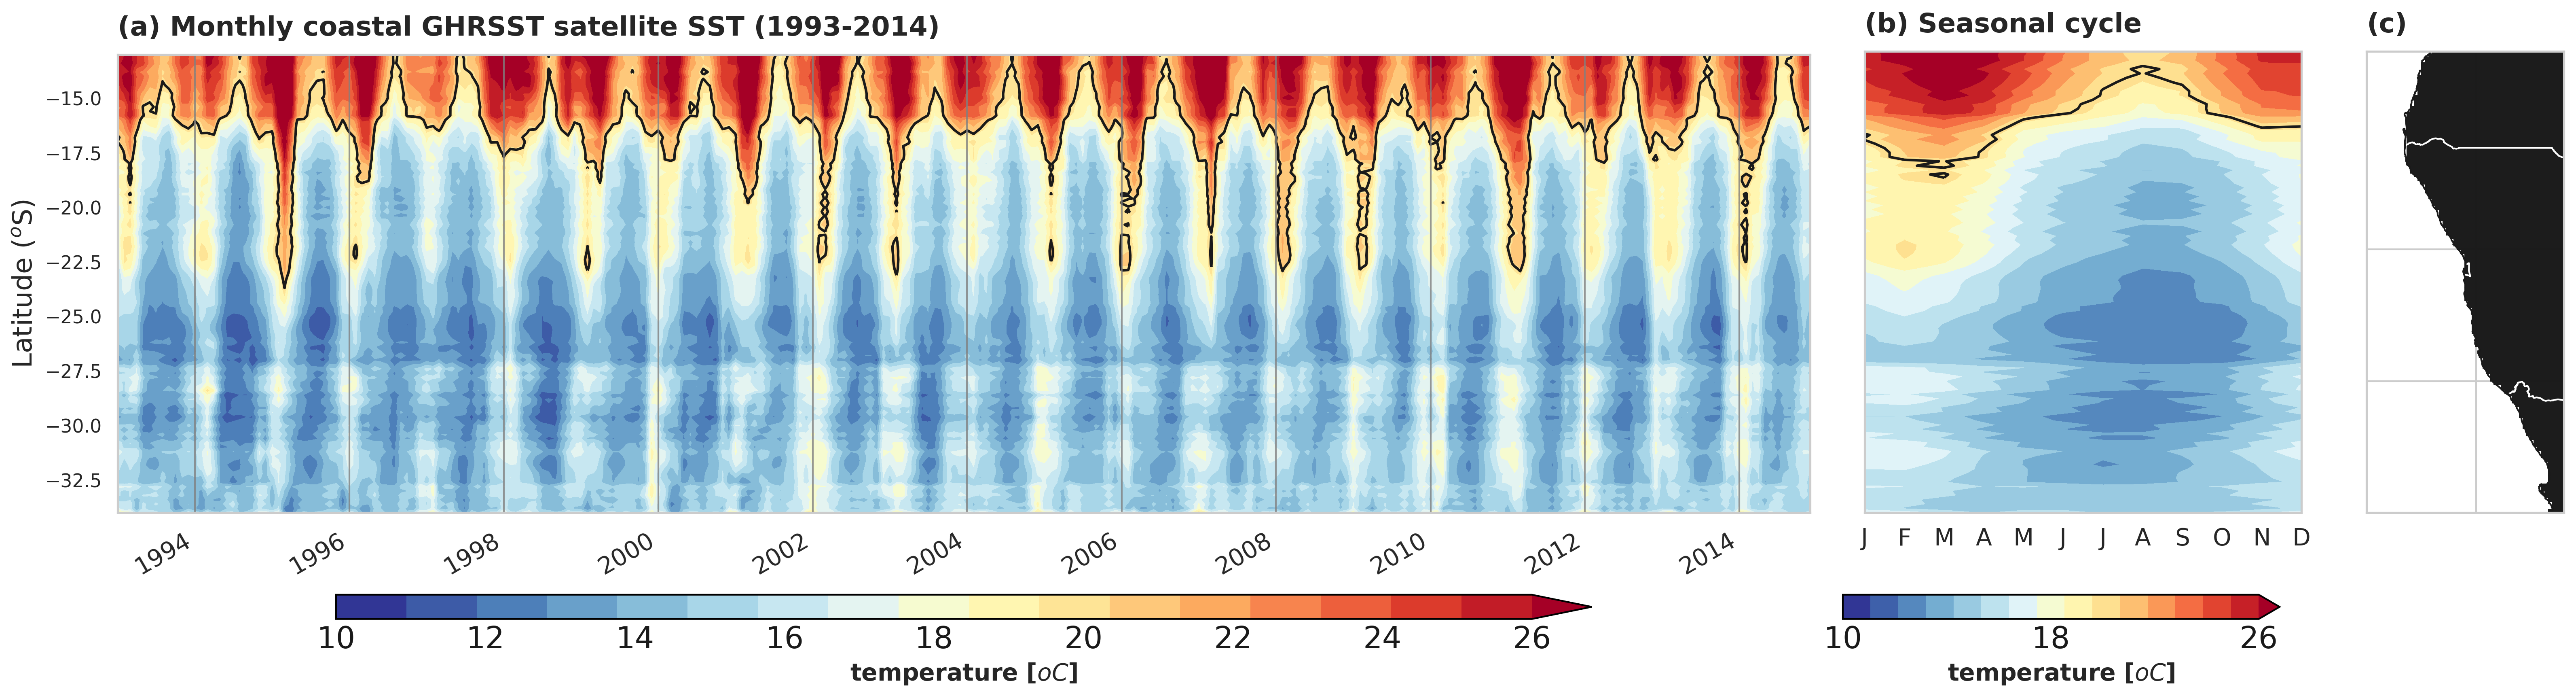

In [8]:
import datetime as dt
import seaborn as sns
import matplotlib.dates as mdates
import geopandas ## in order for the basemap to be imported successfully, geopandas needs to be installed also
from mpl_toolkits.basemap import Basemap
from matplotlib.dates import MonthLocator, YearLocator

## plot the data
#fig = plt.figure(figsize=(18,7),dpi=300, facecolor='white')
#ax1 = fig.add_subplot(1,1,1)

#####PLOTTING STUFF 
T1='1993-01-01'
T2='2014-12-31'

fig = plt.figure(figsize=(18,5),dpi=300, facecolor='white')
ax1 = fig.add_subplot(111)

### plot hoffmoeller plot of var 1 for selected year
sns.set(style="whitegrid")

Y=var1_anom0['lat']
#X=var1_anom0['time'].values.as_matrix(columns=None)
X=var1_anom0['time']
Z=DM_HOFF.T
#X=var1_anom0['time'].as_matrix(columns=None)
Z1=DM_HOFF.T

zmin=10
zmax=26

#zint=0.01
zlevels=18;

ymin=-34
ymax=-13

## major x ticks
txposition = [pd.to_datetime('1994'), pd.to_datetime('1996'), pd.to_datetime('1998'), pd.to_datetime('2000'), pd.to_datetime('2002'), pd.to_datetime('2004'), pd.to_datetime('2006'), pd.to_datetime('2008'), pd.to_datetime('2010'), pd.to_datetime('2012'), pd.to_datetime('2014')] 
## major y ticks
yxposition = [-28,-22] 

cs=Z.plot.contourf(cmap='RdYlBu_r', vmin=zmin, vmax=zmax,levels=zlevels,add_colorbar=False)
Z1.plot.contour(levels=[20], add_colorbar=False,colors=['k'])
ax1.set_ylim(ymin,ymax)



hfmt = md.DateFormatter('%Y')
year = [1994,1996,1998,2000,2002,2004,2006,2008,2010,2012,2014]
dates = [dt.datetime.strptime(str(int(date)),'%Y') for date in year]
xfmt = mdates.DateFormatter('%Y')

ax1.xaxis.set_major_formatter(xfmt)
ax1.set_xticks(dates,minor=False)
labels = ax1.get_xticklabels()
plt.setp(labels, fontsize=14)

for xc in txposition:
    ax1.axvline(x=xc, color='grey', linestyle='-',lw=1,alpha=0.8)
    
    ### add major axis ticks (grid doesn't work in jupyter notebook this is a workaround)
#for xc in yxposition:
#    ax1.axhline(y=xc, color='grey', linestyle='-',lw=1,alpha=0.8)


_=ax1.set_ylabel(u'Latitude ($^{o}$S)', size=16)
_=ax1.set_xlabel(u'', size=14)
# Title    
_ = ax1.set_title('(a) Monthly coastal GHRSST satellite SST (1993-2014)',loc='left',fontsize='16', weight='bold', y=1.02)


cax1 = fig.add_axes([0.225, -0.05, 0.575, 0.04])

cticks=np.linspace(zmin,zmax,zlevels/2)
cb0 = plt.colorbar(cs, orientation = 'horizontal', cax=cax1, ticks=cticks, extend='both', drawedges=True)
cb0.ax.tick_params(axis='x',direction='in', length=7, width=1, colors='k', top='on', labelsize='18')
#cb = plt.colorbar(cs, orientation = 'horizontal',fraction=0.075,ticks=cticks, extend='both', drawedges=True)
#cb.ax.tick_params(axis='x',direction='in', length=7, width=1, colors='k', top='on', labelsize='14')
#[h.set_zorder(0) for h in cb0.ax.findobj(mpl.collections.QuadMesh)]
cb0.set_label('temperature [${o}C$]', fontsize='14', weight='bold')
cb0.outline.set_edgecolor('black')
cb0.outline.set_linewidth(1)
#cb.dividers.set_edgecolor('black')
cb0.dividers.set_linewidth(0)

##############################################################################
### SEASONAL CYCLE
##############################################################################

#cax = fig.add_axes([0.915, 0.31875, 0.20, 0.5813]) ### from print ax.get_position() to work out the values
#cax = fig.add_axes([0.915, 0.1, 0.2, 0.595])
cax = fig.add_axes([0.925, 0.125, 0.20, 0.76])
sns.set(style="whitegrid")

Y=var1_clim['lat']
X=var1_clim['month']
Z=var1_clim.T

smin=10
smax=26
slevels=16

csm=Z.plot.contourf(cmap='RdYlBu_r', vmin=smin, vmax=smax,levels=slevels,add_colorbar=False)
cs=Z.plot.contour(levels=[20], add_colorbar=False,colors=['k'])
#csm=plt.pcolor(timeallc, latallc, ws_clim, cmap=cmap_s, norm=norm_s, zorder=0)
csm.set_clim(smin,smax)

#ax.set_ylim(-35,-12);
#ax.set_xlim(0,12);

### X-Axis
months_lab = ['J','F', 'M', 'A', 'M', 'J', 'J','A', 'S', 'O', 'N', 'D']
cax.set_xlim(1,12)
cax.set_xticks(np.linspace(1,12,12))
cax.set_xticklabels(months_lab, size='14');
cax.tick_params(axis='x', direction='inout', which = 'major', length=10, width=1)
_=cax.set_xlabel(u'')
### Y-Axis
cax.set_ylim(-34,-13);
cax.set_yticks(np.arange(-28,-21, 6.));

cax.set_yticklabels('');
cax.tick_params(axis='y', direction='inout', which = 'major', length=8, width=2)
cax.grid(axis='y', linestyle='-', alpha=0.4)

### Outerbox
#for sp_name,sp_obj in cax.spines.iteritems():
#    sp_obj.set_lw(2) #linewidth
#    sp_obj.set_edgecolor('k')

# Title    
_ = cax.set_title('(b) Seasonal cycle',loc='left',fontsize='16', weight='bold', y=1.02)    
    

_=cax.set_ylabel(u'')

##############################################################################

### Add a colobar - have to add another axes just so that there is one cb for the whole plot
cax = fig.add_axes([0.915, -0.05, 0.2, 0.04])
cticks=np.linspace(smin,smax,3)
#cb = plt.colorbar(csm, orientation = 'horizontal', cax=cax, ticks=cticks, extend='both', drawedges=True)
cb = plt.colorbar(csm, orientation = 'horizontal', cax=cax, ticks=cticks)
cb.ax.tick_params(axis='x',direction='in', length=7, width=1, colors='k', top='on', labelsize='18')
#[h.set_zorder(0) for h in cb.ax.findobj(mpl.collections.QuadMesh)]
cb.set_label('temperature [${o}C$]', fontsize='14', weight='bold')
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1)
#cb.dividers.set_edgecolor('black')
#cb.dividers.set_linewidth(0)
#cb.add_lines(cp)

### Save figure
#plt.savefig(outpath + 'DFS_10speedanoms_hovmoller_b.png', dpi = 300, bbox_inches='tight')


###############################################################################################



#### plot the map 
#wax = fig.add_axes([1.09, 0.3, 0.2, 0.595])
wax = fig.add_axes([1.10, 0.125, 0.2, 0.76]) #0.775

sns.set(style="whitegrid")

lonmax=19
lonmin=10
latmin=-34
latmax=-13

#### Summer
map_ax=Basemap(resolution='i',projection='cyl',llcrnrlat=latmin, llcrnrlon=lonmin, urcrnrlat=latmax, urcrnrlon=lonmax, \
               ax=wax)
map_ax.drawcountries(linewidth=1,color='w')
map_ax.drawcoastlines(linewidth=1)
map_ax.drawlsmask(land_color='k', ocean_color='none', lakes=False, alpha = 0.99, zorder=1, resolution='i')

_= map_ax.ax.set_yticks(np.arange(-28,-21,6.))
_= map_ax.ax.set_xticks(np.arange(lonmin,lonmax,5.)) 

wax.tick_params(labelleft=False)
wax.tick_params(labelbottom=False)


### Outerbox
#for sp_name,sp_obj in wax.spines.iteritems():
#    sp_obj.set_lw(2) #linewidth
#    sp_obj.set_edgecolor('k')

# Title    
_ = wax.set_title('(c)',loc='left',fontsize='16', weight='bold', y=1.02)  


In [57]:
### calculate the detrended anoms
import scipy as scipy
import scipy.stats as stats
import scipy.signal as signal

rows = var1_anom.shape[1]
cols = var1_anom.shape[0]

fvar1_anom=var1_anom*0
dvar1_anom=var1_anom*0

for x in range(cols):
    a=var1_anom[x,:]
    fill_a=a.values
    fvar1_anom[x,:]=fill_a
    da=scipy.signal.detrend(fill_a[:])
    dvar1_anom[x,:]=da

/home/jenny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/jenny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:176: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/jenny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:177: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


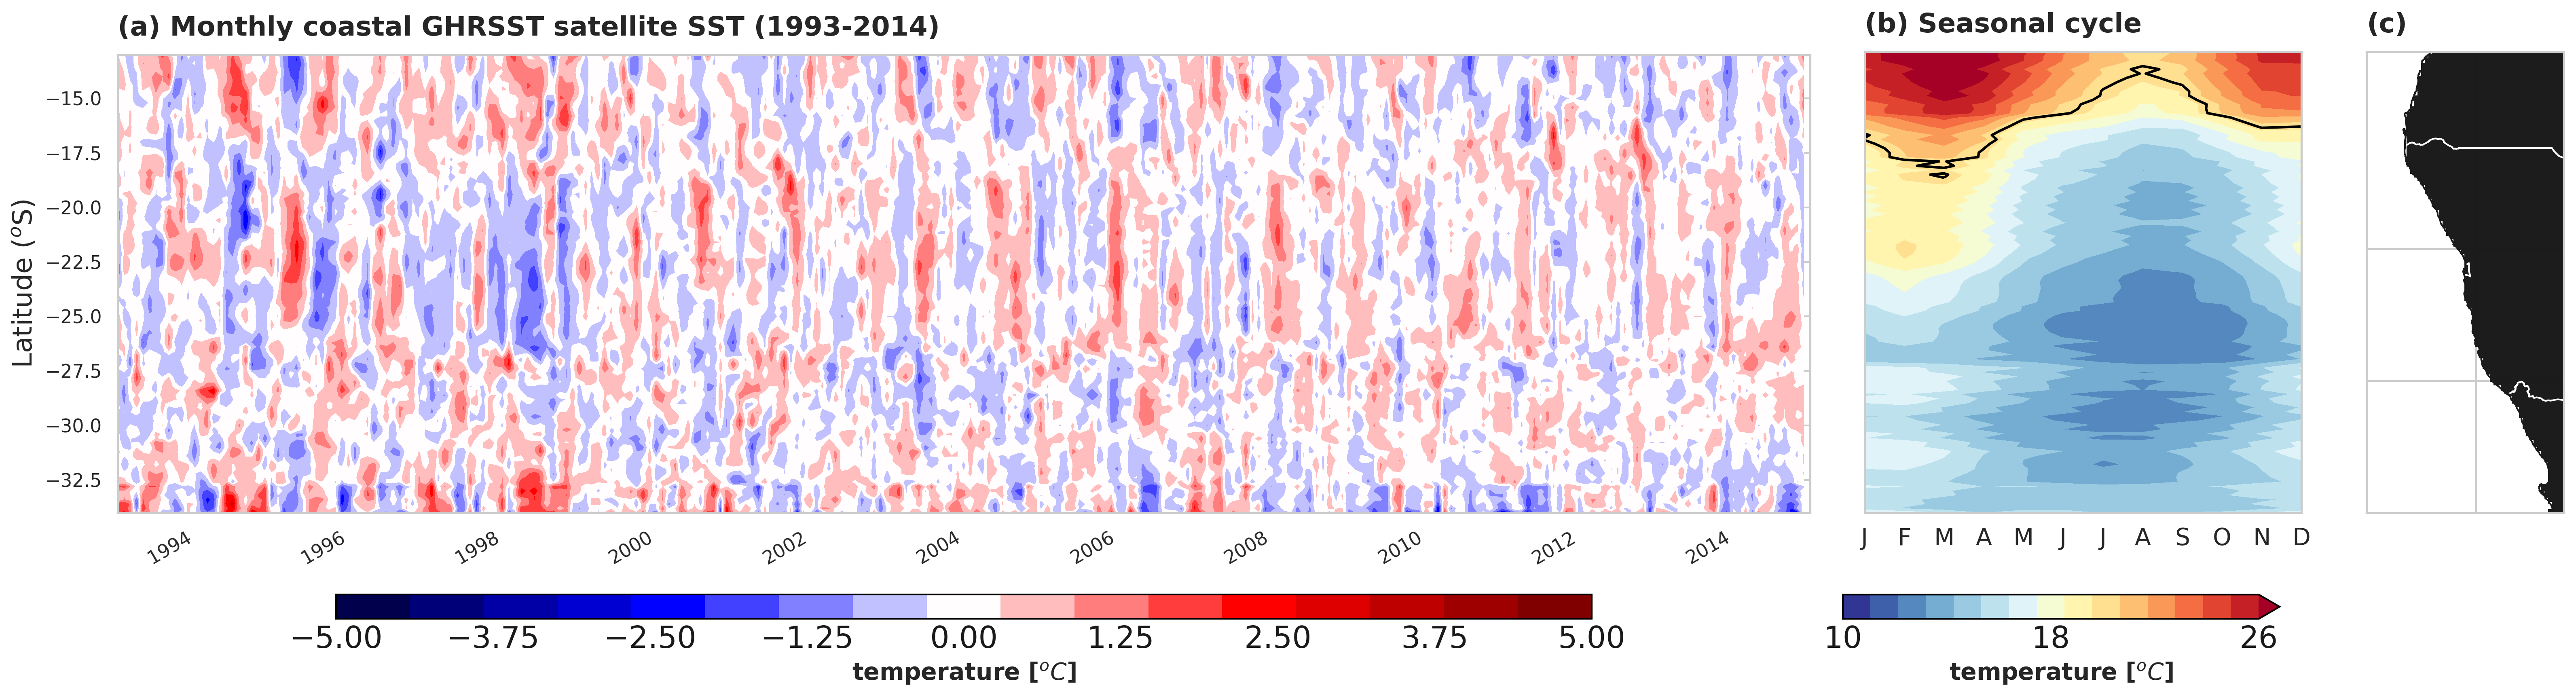

In [59]:
import seaborn as sns
import matplotlib.dates as mdates
import geopandas ## in order for the basemap to be imported successfully, geopandas needs to be installed also
from mpl_toolkits.basemap import Basemap


## plot the data
#fig = plt.figure(figsize=(18,7),dpi=300, facecolor='white')
#ax1 = fig.add_subplot(1,1,1)

#####PLOTTING STUFF 
T1='1993-01-01'
T2='2014-12-31'

fig = plt.figure(figsize=(18,5),dpi=300, facecolor='white')
ax1 = fig.add_subplot(111)

### plot hoffmoeller plot of var 1 for selected year
sns.set(style="whitegrid")

Y=var1_anom['lat']
X=var1_anom['time']
#X=var1_anom0['time'].as_matrix(columns=None)
#Z=dvar1_anom.T

Z=dvar1_anom.T

zmin=-5
zmax=5

#zint=0.01
zlevels=18;

ymin=-34
ymax=-13



cs=Z.plot.contourf(cmap='seismic', vmin=zmin, vmax=zmax,levels=zlevels,add_colorbar=False)
Z.plot.contour(levels=[20], add_colorbar=False,colors=['k'])
ax1.set_ylim(ymin,ymax)
ax1.set_xlim(pd.Timestamp(T1), pd.Timestamp(T2))
ticks=['1994','1996','1998','2000','2002','2004','2006','2008','2010','2012','2014']
ax1.set_xticks(ticks, minor=False)

## tick labels for x-axis
hfmt = md.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(hfmt)
ax1.xaxis.grid(True, which='major')
ax1.yaxis.grid(True, which='major')
#ax1.set_xticklabels(xfmt, fontsize='14')
### add major axis ticks (grid doesn't work in jupyter notebook this is a workaround)


#ax1.set_xlim(1980,2015)
_=ax1.set_ylabel(u'Latitude ($^{o}$S)', size=16)
_=ax1.set_xlabel(u'', size=14)
# Title    
_ = ax1.set_title('(a) Monthly coastal GHRSST satellite SST (1993-2014)',loc='left',fontsize='16', weight='bold', y=1.02)



### add El Nino events in timeseries

#for xc in elxposition:
#    ax1.axvline(x=xc, color='k', linestyle='-',lw=3)
    
    ### add la Nino events in timeseries

#for xc in laxposition:
#    ax1.axvline(x=xc, color='k', linestyle='--',lw=3)
    
#ax1.axvline(pd.to_datetime('1992-01'), color='r', linestyle='--', lw=1)
cax1 = fig.add_axes([0.225, -0.05, 0.575, 0.04])

cticks=np.linspace(zmin,zmax,zlevels/2)
cb0 = plt.colorbar(cs, orientation = 'horizontal', cax=cax1, ticks=cticks, extend='both', drawedges=True)
cb0.ax.tick_params(axis='x',direction='in', length=7, width=1, colors='k', top='on', labelsize='18')
#cb = plt.colorbar(cs, orientation = 'horizontal',fraction=0.075,ticks=cticks, extend='both', drawedges=True)
#cb.ax.tick_params(axis='x',direction='in', length=7, width=1, colors='k', top='on', labelsize='14')
#[h.set_zorder(0) for h in cb0.ax.findobj(mpl.collections.QuadMesh)]
cb0.set_label('temperature [$^{o}C$]', fontsize='14', weight='bold')
cb0.outline.set_edgecolor('black')
cb0.outline.set_linewidth(1)
#cb.dividers.set_edgecolor('black')
cb0.dividers.set_linewidth(0)

##############################################################################
### SEASONAL CYCLE
##############################################################################

#cax = fig.add_axes([0.915, 0.31875, 0.20, 0.5813]) ### from print ax.get_position() to work out the values
#cax = fig.add_axes([0.915, 0.1, 0.2, 0.595])
cax = fig.add_axes([0.925, 0.125, 0.20, 0.76])
sns.set(style="whitegrid")

Y=var1_clim['lat']
X=var1_clim['month']
Z=var1_clim.T

smin=10
smax=26
slevels=16

csm=Z.plot.contourf(cmap='RdYlBu_r', vmin=smin, vmax=smax,levels=slevels,add_colorbar=False)
cs=Z.plot.contour(levels=[20], add_colorbar=False,colors=['black'])
#csm=plt.pcolor(timeallc, latallc, ws_clim, cmap=cmap_s, norm=norm_s, zorder=0)
csm.set_clim(smin,smax)

#ax.set_ylim(-35,-12);
#ax.set_xlim(0,12);

### X-Axis
months_lab = ['J','F', 'M', 'A', 'M', 'J', 'J','A', 'S', 'O', 'N', 'D']
cax.set_xlim(1,12)
cax.set_xticks(np.linspace(1,12,12))
cax.set_xticklabels(months_lab, size='14');
cax.tick_params(axis='x', direction='inout', which = 'major', length=10, width=1)
_=cax.set_xlabel(u'')
### Y-Axis
cax.set_ylim(-34,-13);
cax.set_yticks(np.arange(-28,-21, 6.));

cax.set_yticklabels('');
cax.tick_params(axis='y', direction='inout', which = 'major', length=8, width=2)
cax.grid(axis='y', linestyle='-', alpha=0.4)

### Outerbox
#for sp_name,sp_obj in cax.spines.iteritems():
#    sp_obj.set_lw(2) #linewidth
#    sp_obj.set_edgecolor('k')

# Title    
_ = cax.set_title('(b) Seasonal cycle',loc='left',fontsize='16', weight='bold', y=1.02)    
    

_=cax.set_ylabel(u'')

##############################################################################

### Add a colobar - have to add another axes just so that there is one cb for the whole plot
cax = fig.add_axes([0.915, -0.05, 0.2, 0.04])
cticks=np.linspace(smin,smax,3)
#cb = plt.colorbar(csm, orientation = 'horizontal', cax=cax, ticks=cticks, extend='both', drawedges=True)
cb = plt.colorbar(csm, orientation = 'horizontal', cax=cax, ticks=cticks)
cb.ax.tick_params(axis='x',direction='in', length=7, width=1, colors='k', top='on', labelsize='18')
#[h.set_zorder(0) for h in cb.ax.findobj(mpl.collections.QuadMesh)]
cb.set_label('temperature [$^{o}C$]', fontsize='14', weight='bold')
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1)
#cb.dividers.set_edgecolor('black')
#cb.dividers.set_linewidth(0)
#cb.add_lines(cp)

### Save figure
#plt.savefig(outpath + 'DFS_10speedanoms_hovmoller_b.png', dpi = 300, bbox_inches='tight')


###############################################################################################



#### plot the map 
#wax = fig.add_axes([1.09, 0.3, 0.2, 0.595])
wax = fig.add_axes([1.10, 0.125, 0.2, 0.76]) #0.775

sns.set(style="whitegrid")

lonmax=19
lonmin=10
latmin=-34
latmax=-13

#### Summer
map_ax=Basemap(resolution='i',projection='cyl',llcrnrlat=latmin, llcrnrlon=lonmin, urcrnrlat=latmax, urcrnrlon=lonmax, \
               ax=wax)
map_ax.drawcountries(linewidth=1,color='w')
map_ax.drawcoastlines(linewidth=1)
map_ax.drawlsmask(land_color='k', ocean_color='none', lakes=False, alpha = 0.99, zorder=1, resolution='i')

_= map_ax.ax.set_yticks(np.arange(-28,-21,6.))
_= map_ax.ax.set_xticks(np.arange(lonmin,lonmax,5.)) 

wax.tick_params(labelleft=False)
wax.tick_params(labelbottom=False)


### Outerbox
#for sp_name,sp_obj in wax.spines.iteritems():
#    sp_obj.set_lw(2) #linewidth
#    sp_obj.set_edgecolor('k')

# Title    
_ = wax.set_title('(c)',loc='left',fontsize='16', weight='bold', y=1.02)  


In [50]:
### calculate the detrended anoms
import scipy as scipy
import scipy.stats as stats
import scipy.signal as signal

rows = var1_anom.shape[1]
cols = var1_anom.shape[0]

fvar1_anom=var1_anom*0
dvar1_anom=var1_anom*0

for x in range(cols):
    a=DM_HOFF[x,:]
    fill_a=a.values
    fvar1_anom[x,:]=fill_a
    da=scipy.signal.detrend(fill_a[:])
    dvar1_anom[x,:]=da

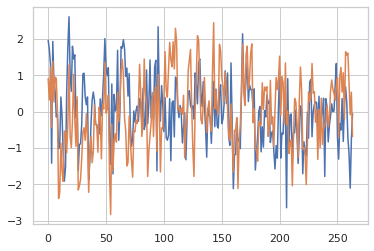

In [47]:
a1=dvar1_anom[:,1].values
a2=var1_anom[:,1].values
a2
plt.plot(a1)
plt.plot(a2)

/home/jenny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:78: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


ZeroDivisionError: float division by zero

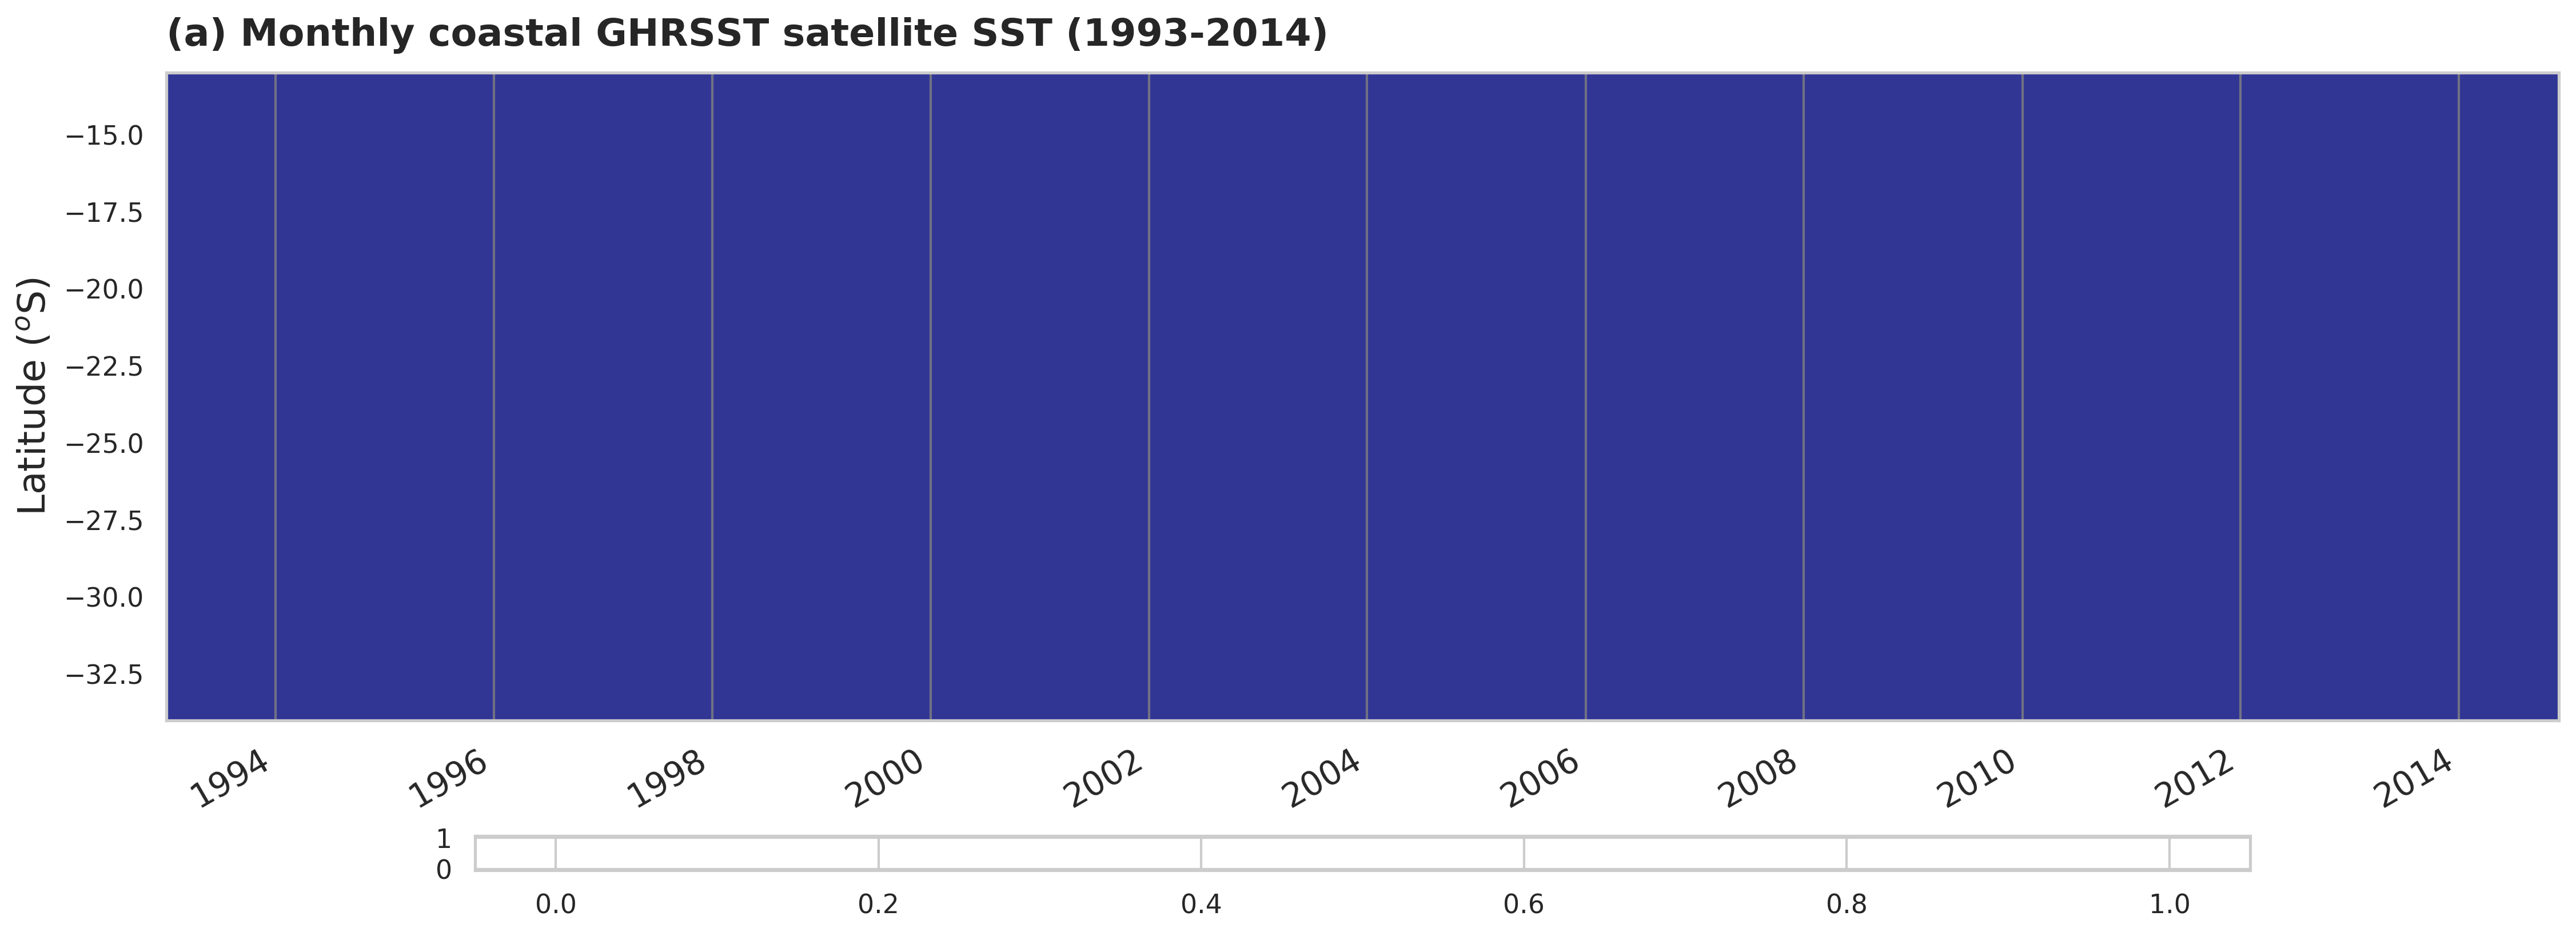

In [52]:
import datetime as dt
import seaborn as sns
import matplotlib.dates as mdates
import geopandas ## in order for the basemap to be imported successfully, geopandas needs to be installed also
from mpl_toolkits.basemap import Basemap
from matplotlib.dates import MonthLocator, YearLocator

## plot the data
#fig = plt.figure(figsize=(18,7),dpi=300, facecolor='white')
#ax1 = fig.add_subplot(1,1,1)

#####PLOTTING STUFF 
T1='1993-01-01'
T2='2014-12-31'

fig = plt.figure(figsize=(18,5),dpi=300, facecolor='white')
ax1 = fig.add_subplot(111)

### plot hoffmoeller plot of var 1 for selected year
sns.set(style="whitegrid")

Y=var1_anom0['lat']
#X=var1_anom0['time'].values.as_matrix(columns=None)
X=var1_anom0['time']
Z=dvar1_anom.T
#X=var1_anom0['time'].as_matrix(columns=None)
Z1=DM_HOFF.T

#Z=Z1+Z0

zmin=10
zmax=26

#zint=0.01
zlevels=18;

ymin=-34
ymax=-13

## major x ticks
txposition = [pd.to_datetime('1994'), pd.to_datetime('1996'), pd.to_datetime('1998'), pd.to_datetime('2000'), pd.to_datetime('2002'), pd.to_datetime('2004'), pd.to_datetime('2006'), pd.to_datetime('2008'), pd.to_datetime('2010'), pd.to_datetime('2012'), pd.to_datetime('2014')] 
## major y ticks
yxposition = [-28,-22] 

cs=Z.plot.contourf(cmap='RdYlBu_r', vmin=zmin, vmax=zmax,levels=zlevels,add_colorbar=False)
cs=Z.plot.contour(levels=[20], add_colorbar=False,colors=['k'])
#cs=Z1.plot.contour(levels=[20], add_colorbar=False,colors=['w'])
ax1.set_ylim(ymin,ymax)



hfmt = md.DateFormatter('%Y')
year = [1994,1996,1998,2000,2002,2004,2006,2008,2010,2012,2014]
dates = [dt.datetime.strptime(str(int(date)),'%Y') for date in year]
xfmt = mdates.DateFormatter('%Y')

ax1.xaxis.set_major_formatter(xfmt)
ax1.set_xticks(dates,minor=False)
labels = ax1.get_xticklabels()
plt.setp(labels, fontsize=14)

for xc in txposition:
    ax1.axvline(x=xc, color='grey', linestyle='-',lw=1,alpha=0.8)
    
    ### add major axis ticks (grid doesn't work in jupyter notebook this is a workaround)
#for xc in yxposition:
#    ax1.axhline(y=xc, color='grey', linestyle='-',lw=1,alpha=0.8)


_=ax1.set_ylabel(u'Latitude ($^{o}$S)', size=16)
_=ax1.set_xlabel(u'', size=14)
# Title    
_ = ax1.set_title('(a) Monthly coastal GHRSST satellite SST (1993-2014)',loc='left',fontsize='16', weight='bold', y=1.02)


cax1 = fig.add_axes([0.225, -0.05, 0.575, 0.04])

cticks=np.linspace(zmin,zmax,zlevels/2)
cb0 = plt.colorbar(cs, orientation = 'horizontal', cax=cax1, ticks=cticks, extend='both', drawedges=True)
cb0.ax.tick_params(axis='x',direction='in', length=7, width=1, colors='k', top='on', labelsize='18')
#cb = plt.colorbar(cs, orientation = 'horizontal',fraction=0.075,ticks=cticks, extend='both', drawedges=True)
#cb.ax.tick_params(axis='x',direction='in', length=7, width=1, colors='k', top='on', labelsize='14')
#[h.set_zorder(0) for h in cb0.ax.findobj(mpl.collections.QuadMesh)]
cb0.set_label('temperature [${o}C$]', fontsize='14', weight='bold')
cb0.outline.set_edgecolor('black')
cb0.outline.set_linewidth(1)
#cb.dividers.set_edgecolor('black')
cb0.dividers.set_linewidth(0)

##############################################################################
### SEASONAL CYCLE
##############################################################################

#cax = fig.add_axes([0.915, 0.31875, 0.20, 0.5813]) ### from print ax.get_position() to work out the values
#cax = fig.add_axes([0.915, 0.1, 0.2, 0.595])
cax = fig.add_axes([0.925, 0.125, 0.20, 0.76])
sns.set(style="whitegrid")

Y=var1_clim['lat']
X=var1_clim['month']
Z=var1_clim.T

smin=10
smax=26
slevels=16

csm=Z.plot.contourf(cmap='RdYlBu_r', vmin=smin, vmax=smax,levels=slevels,add_colorbar=False)
cs=Z.plot.contour(levels=[20], add_colorbar=False,colors=['k'])

#csm=plt.pcolor(timeallc, latallc, ws_clim, cmap=cmap_s, norm=norm_s, zorder=0)
csm.set_clim(smin,smax)

#ax.set_ylim(-35,-12);
#ax.set_xlim(0,12);

### X-Axis
months_lab = ['J','F', 'M', 'A', 'M', 'J', 'J','A', 'S', 'O', 'N', 'D']
cax.set_xlim(1,12)
cax.set_xticks(np.linspace(1,12,12))
cax.set_xticklabels(months_lab, size='14');
cax.tick_params(axis='x', direction='inout', which = 'major', length=10, width=1)
_=cax.set_xlabel(u'')
### Y-Axis
cax.set_ylim(-34,-13);
cax.set_yticks(np.arange(-28,-21, 6.));

cax.set_yticklabels('');
cax.tick_params(axis='y', direction='inout', which = 'major', length=8, width=2)
cax.grid(axis='y', linestyle='-', alpha=0.4)

### Outerbox
#for sp_name,sp_obj in cax.spines.iteritems():
#    sp_obj.set_lw(2) #linewidth
#    sp_obj.set_edgecolor('k')

# Title    
_ = cax.set_title('(b) Seasonal cycle',loc='left',fontsize='16', weight='bold', y=1.02)    
    

_=cax.set_ylabel(u'')

##############################################################################

### Add a colobar - have to add another axes just so that there is one cb for the whole plot
cax = fig.add_axes([0.915, -0.05, 0.2, 0.04])
cticks=np.linspace(smin,smax,3)
#cb = plt.colorbar(csm, orientation = 'horizontal', cax=cax, ticks=cticks, extend='both', drawedges=True)
cb = plt.colorbar(csm, orientation = 'horizontal', cax=cax, ticks=cticks)
cb.ax.tick_params(axis='x',direction='in', length=7, width=1, colors='k', top='on', labelsize='18')
#[h.set_zorder(0) for h in cb.ax.findobj(mpl.collections.QuadMesh)]
cb.set_label('temperature [${o}C$]', fontsize='14', weight='bold')
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1)
#cb.dividers.set_edgecolor('black')
#cb.dividers.set_linewidth(0)
#cb.add_lines(cp)

### Save figure
#plt.savefig(outpath + 'DFS_10speedanoms_hovmoller_b.png', dpi = 300, bbox_inches='tight')


###############################################################################################



#### plot the map 
#wax = fig.add_axes([1.09, 0.3, 0.2, 0.595])
wax = fig.add_axes([1.10, 0.125, 0.2, 0.76]) #0.775

sns.set(style="whitegrid")

lonmax=19
lonmin=10
latmin=-34
latmax=-13

#### Summer
map_ax=Basemap(resolution='i',projection='cyl',llcrnrlat=latmin, llcrnrlon=lonmin, urcrnrlat=latmax, urcrnrlon=lonmax, \
               ax=wax)
map_ax.drawcountries(linewidth=1,color='w')
map_ax.drawcoastlines(linewidth=1)
map_ax.drawlsmask(land_color='k', ocean_color='none', lakes=False, alpha = 0.99, zorder=1, resolution='i')

_= map_ax.ax.set_yticks(np.arange(-28,-21,6.))
_= map_ax.ax.set_xticks(np.arange(lonmin,lonmax,5.)) 

wax.tick_params(labelleft=False)
wax.tick_params(labelbottom=False)


### Outerbox
#for sp_name,sp_obj in wax.spines.iteritems():
#    sp_obj.set_lw(2) #linewidth
#    sp_obj.set_edgecolor('k')

# Title    
_ = wax.set_title('(c)',loc='left',fontsize='16', weight='bold', y=1.02)  
